In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

#for replicability purposes
tf.random.set_seed(91195003)
#for an easy reset backend session state
tf.keras.backend.clear_session()

In [2]:
n_variate = 2

In [3]:

#Load dataset
def load_dataset(path=r'yahoo_stock.csv'):
  return pd.read_csv(path)

In [4]:
#split data into training and validation sets
def split_data(training, perc=10):
  train_idx = np.arange(0, int(len(training)*(100-perc)/100))
  val_idx = np.arange(int(len(training)*(100-perc)/100+1), len(training))
  return train_idx, val_idx

In [5]:
def prepare_data(df):
  df_aux = df.drop(columns=['High', 'Low', 'Volume', 'Adj Close'], inplace=False)
  df_aux = df_aux.set_index('Date')
  return df_aux

In [6]:
def data_normalization(df, norm_range=(-1, 1)):
  #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
  scaler = MinMaxScaler(feature_range=norm_range)
  df[['Open']] = scaler.fit_transform(df[['Open']])
  df[['Close']] = scaler.fit_transform(df[['Close']])
  return scaler

In [7]:
#plot learning curve
def plot_learning_curves(history, epochs):
  #accuracies and losses
  #dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse'])
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  epochs_range = range(epochs)
  #creating figure
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label='Training Loss')
  plt.plot(epochs_range,val_loss,label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training/Validation Loss')
  plt.show()

In [8]:
#Plot time series data
def plot_confirmed_cases(data):
  plt.figure(figsize=(8,6))
  plt.plot(range(len(data)), data)
  plt.title('Confirmed Cases of COVID-19')
  plt.ylabel('Cases')
  plt.xlabel('Days')
  plt.show()

In [9]:
#Preparing the dataset for the LSTM
def to_supervised(df, timesteps):
  data = df.values
  X, y = list(), list()
  #iterate over the training set to create X and y
  dataset_size = len(data)
  for curr_pos in range(dataset_size):
    #end of the input sequence is the current position + the number of timesteps of the input sequence
    input_index = curr_pos + timesteps
    #end of the labels corresponds to the end of the input sequence + 1
    label_index = input_index + 1
    #if we have enough data for this sequence
    if label_index < dataset_size:
      X.append(data[curr_pos:input_index, :])
      y.append(data[input_index:label_index, 1])
  #using np.float32 for GPU performance
  return np.array(X).astype('float32'), np.array(y).astype('float32')

In [10]:
#Building the model
def rmse(y_true, y_pred):
  return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))


In [11]:
def build_model(timesteps, features, h_neurons=64, activation='tanh'):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(h_neurons, activation=activation, input_shape=(timesteps, features), return_sequences=True))
  #Add a new layer
  model.add(tf.keras.layers.LSTM(32, activation=activation ,return_sequences=False))
  #
  model.add(tf.keras.layers.Dense(h_neurons, activation=activation))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(n_variate, activation='linear'))
  #model summary (and save it as PNG)
  tf.keras.utils.plot_model(model, 'yahoo_model.png', show_shapes=True)
  return model

In [12]:
#Compiling and fit the model
def compile_and_fit(model, epochs, batch_size):
  #compile
  model.compile(loss = rmse, optimizer = tf.keras.optimizers.Adam(), metrics = ['mae', rmse])
  #fit
  hist_list = list()
  loss_list = list()

  #callback
  #saving in Keras HDF5 (or h5), a binary data format
  callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath='my_model_{epoch}_{val_loss:.3f}.h5',#path where to save model
        save_best_only=True,#overwrite the current checkpoint if and only if
        monitor='val_loss',#the val_loss score has improved
        save_weights_only=False,#if True, only the weigths are saved
        verbose=1,#verbosity mode
        period=5 #save ony at the fifth epoch (5 em 5 epocas) 
        )#,
    #interrupt training if loss stops improving for over 2 epochs
    #tf.keras.callbacks.EarlyStopping(patience=9, monitor='cost')
    ]

  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=cv_splits)
  for train_index, test_index in tscv.split(X):
    train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
    #build data
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_index], y[test_index]

    #print("x_val::::",X_val,"\n","y_val:",y_val,"\n")

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, shuffle=False, callbacks=callbacks)
    metrics = model.evaluate(X_test, y_test)


    plot_learning_curves(history, epochs)
    hist_list.append(history)


  return model, hist_list

In [13]:
#Main Execution
#the dataframes
df_raw = load_dataset()
#Get data from 2015 to the end of 2018
df_raw = df_raw[:1134]
df_data = prepare_data(df_raw)
df = df_data.copy()

scaler = data_normalization(df) #scaling data to [-1, 1]

In [14]:
#Recursive Multi-Step Forecast!!!
def forecast(model, df, timesteps, multisteps, scaler):
  input_seq = np.array(df[-timesteps:].values) #getting the last sequence of known value
  inp = input_seq
  #print("Input_seq: ",inp)
  forecasts = list()

  #multisteps tells us how many iterations we want to perform, i.e., how many days we want to predict
  for step in range(1, multisteps+1):
    inp = inp.reshape(1,timesteps,n_variate)
    yhat = model.predict(inp) #dá o valor predito normalizado
    yhat_desnormalized = scaler.inverse_transform(yhat) #dá valor predito desnormalizado
    forecasts.append(yhat_desnormalized) #adicionar previsao à lista final de previsões
    #preparar novo input para fazer previsão para o dia seguinte
    #inp= np.append(inp[0],[[yhat[0][0],yhat[0][1]]],axis=0) #adiciona previsão recente ao input
    #inp = inp[-timesteps:] #vai ao input buscar os ultimos timesteps registados
  print(forecasts)
  return forecasts

In [15]:
def plot_forecast(data, forecasts):

  plt.figure(figsize=(8,6))
  plt.plot(range(len(data)), data['Open'], color='green', label='True value')
  plt.plot(range(len(data)-1, len(data)+len(forecasts)-1), forecasts, color='red', label='Forecasts')
  plt.title('Yahoo stock price')
  plt.ylabel('Value')
  plt.xlabel('Days')
  plt.legend()
  plt.show()

# Tunning

In [16]:
tunning_dict = {               
                1: {'timesteps' : 7, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 10,  'batch_size' : 5 },
                2: {'timesteps' : 7, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 50,  'batch_size' : 5 },
                3: {'timesteps' : 7, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 100,  'batch_size' : 5 },

                #
                4: {'timesteps' : 8, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 60,  'batch_size' : 5 },
                5: {'timesteps' : 8, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 5 },
                6: {'timesteps' : 8, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 5 },
                #
                7: {'timesteps' : 10, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 50,  'batch_size' : 8 },
                8: {'timesteps' : 10, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 8 },
                9: {'timesteps' : 10, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 8 }

                }
# record da history de cada modelo
record = {}

Epoch 1/10
51/51 [==============================] - 5s 30ms/step - loss: 0.3238 - mae: 0.3125 - rmse: 0.3238 - val_loss: 0.0219 - val_mae: 0.0190 - val_rmse: 0.0224
Epoch 2/10
51/51 [==============================] - 0s 9ms/step - loss: 0.1422 - mae: 0.1286 - rmse: 0.1422 - val_loss: 0.0360 - val_mae: 0.0287 - val_rmse: 0.0364
Epoch 3/10
51/51 [==============================] - 0s 8ms/step - loss: 0.1590 - mae: 0.1454 - rmse: 0.1590 - val_loss: 0.0923 - val_mae: 0.0904 - val_rmse: 0.0930
Epoch 4/10
51/51 [==============================] - 0s 9ms/step - loss: 0.1343 - mae: 0.1177 - rmse: 0.1343 - val_loss: 0.0773 - val_mae: 0.0767 - val_rmse: 0.0779
Epoch 5/10
51/51 [==============================] - 0s 9ms/step - loss: 0.1338 - mae: 0.1217 - rmse: 0.1338 - val_loss: 0.0579 - val_mae: 0.0572 - val_rmse: 0.0584

Epoch 00005: val_loss improved from inf to 0.05786, saving model to my_model_5_0.058.h5
Epoch 6/10
51/51 [==============================] - 0s 9ms/step - loss: 0.1568 - mae: 0.14

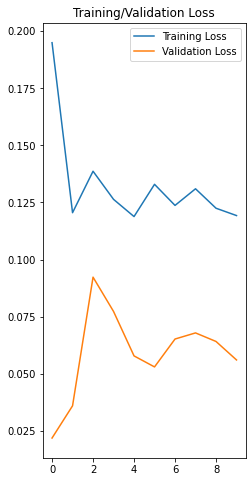

Epoch 1/10
102/102 [==============================] - 1s 9ms/step - loss: 0.1046 - mae: 0.0977 - rmse: 0.1045 - val_loss: 0.0278 - val_mae: 0.0246 - val_rmse: 0.0277
Epoch 2/10
102/102 [==============================] - 1s 8ms/step - loss: 0.1324 - mae: 0.1261 - rmse: 0.1318 - val_loss: 0.0464 - val_mae: 0.0447 - val_rmse: 0.0476
Epoch 3/10
102/102 [==============================] - 1s 8ms/step - loss: 0.1112 - mae: 0.1048 - rmse: 0.1108 - val_loss: 0.0333 - val_mae: 0.0306 - val_rmse: 0.0340
Epoch 4/10
102/102 [==============================] - 1s 8ms/step - loss: 0.1003 - mae: 0.0932 - rmse: 0.0999 - val_loss: 0.0507 - val_mae: 0.0480 - val_rmse: 0.0518
Epoch 5/10
102/102 [==============================] - 1s 8ms/step - loss: 0.0920 - mae: 0.0850 - rmse: 0.0918 - val_loss: 0.0265 - val_mae: 0.0239 - val_rmse: 0.0268

Epoch 00005: val_loss improved from 0.05609 to 0.02650, saving model to my_model_5_0.026.h5
Epoch 6/10
102/102 [==============================] - 1s 8ms/step - loss: 0.0

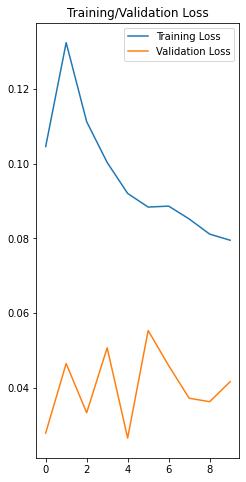

Epoch 1/10
152/152 [==============================] - 2s 7ms/step - loss: 0.0703 - mae: 0.0639 - rmse: 0.0703 - val_loss: 0.1169 - val_mae: 0.1108 - val_rmse: 0.1167
Epoch 2/10
152/152 [==============================] - 1s 7ms/step - loss: 0.0637 - mae: 0.0570 - rmse: 0.0637 - val_loss: 0.0744 - val_mae: 0.0656 - val_rmse: 0.0758
Epoch 3/10
152/152 [==============================] - 1s 6ms/step - loss: 0.0528 - mae: 0.0459 - rmse: 0.0528 - val_loss: 0.0725 - val_mae: 0.0633 - val_rmse: 0.0738
Epoch 4/10
152/152 [==============================] - 1s 6ms/step - loss: 0.0631 - mae: 0.0562 - rmse: 0.0631 - val_loss: 0.0801 - val_mae: 0.0701 - val_rmse: 0.0814
Epoch 5/10
152/152 [==============================] - 1s 6ms/step - loss: 0.0560 - mae: 0.0487 - rmse: 0.0560 - val_loss: 0.0687 - val_mae: 0.0602 - val_rmse: 0.0698

Epoch 00005: val_loss did not improve from 0.02650
Epoch 6/10
152/152 [==============================] - 1s 6ms/step - loss: 0.0571 - mae: 0.0505 - rmse: 0.0571 - val_lo

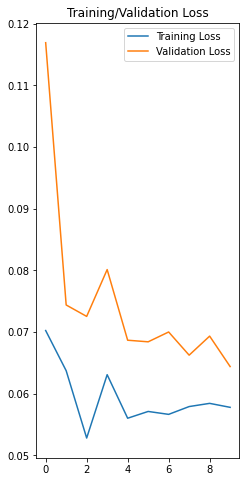

[array([[2517.452 , 2519.5168]], dtype=float32)]
[array([[2517.452 , 2519.5168]], dtype=float32)]
[2517.452]


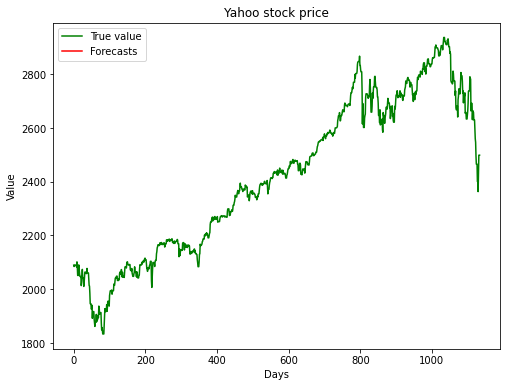

Epoch 1/50
51/51 [==============================] - 5s 25ms/step - loss: 0.3366 - mae: 0.3257 - rmse: 0.3366 - val_loss: 0.0129 - val_mae: 0.0109 - val_rmse: 0.0124
Epoch 2/50
51/51 [==============================] - 0s 9ms/step - loss: 0.1622 - mae: 0.1501 - rmse: 0.1622 - val_loss: 0.0409 - val_mae: 0.0344 - val_rmse: 0.0414
Epoch 3/50
51/51 [==============================] - 0s 9ms/step - loss: 0.1556 - mae: 0.1424 - rmse: 0.1556 - val_loss: 0.0930 - val_mae: 0.0923 - val_rmse: 0.0936
Epoch 4/50
51/51 [==============================] - 0s 9ms/step - loss: 0.1310 - mae: 0.1189 - rmse: 0.1310 - val_loss: 0.0821 - val_mae: 0.0811 - val_rmse: 0.0827
Epoch 5/50
51/51 [==============================] - 0s 9ms/step - loss: 0.1416 - mae: 0.1301 - rmse: 0.1416 - val_loss: 0.0510 - val_mae: 0.0497 - val_rmse: 0.0515

Epoch 00005: val_loss improved from inf to 0.05097, saving model to my_model_5_0.051.h5
Epoch 6/50
51/51 [==============================] - 0s 9ms/step - loss: 0.1708 - mae: 0.16

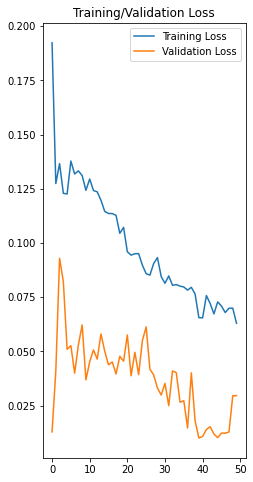

Epoch 1/50
102/102 [==============================] - 1s 8ms/step - loss: 0.0472 - mae: 0.0405 - rmse: 0.0470 - val_loss: 0.0211 - val_mae: 0.0183 - val_rmse: 0.0221
Epoch 2/50
102/102 [==============================] - 1s 9ms/step - loss: 0.0603 - mae: 0.0544 - rmse: 0.0601 - val_loss: 0.0176 - val_mae: 0.0147 - val_rmse: 0.0180
Epoch 3/50
102/102 [==============================] - 1s 9ms/step - loss: 0.0617 - mae: 0.0563 - rmse: 0.0614 - val_loss: 0.0177 - val_mae: 0.0151 - val_rmse: 0.0183
Epoch 4/50
102/102 [==============================] - 1s 8ms/step - loss: 0.0565 - mae: 0.0512 - rmse: 0.0563 - val_loss: 0.0192 - val_mae: 0.0163 - val_rmse: 0.0199
Epoch 5/50
102/102 [==============================] - 1s 8ms/step - loss: 0.0525 - mae: 0.0467 - rmse: 0.0523 - val_loss: 0.0217 - val_mae: 0.0190 - val_rmse: 0.0228

Epoch 00005: val_loss did not improve from 0.01003
Epoch 6/50
102/102 [==============================] - 1s 8ms/step - loss: 0.0508 - mae: 0.0446 - rmse: 0.0506 - val_lo

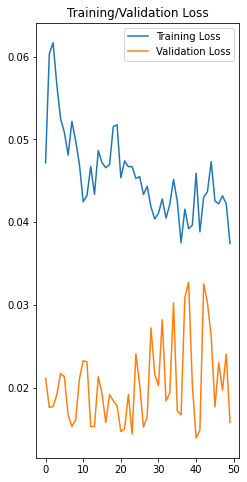

Epoch 1/50
152/152 [==============================] - 3s 7ms/step - loss: 0.0424 - mae: 0.0361 - rmse: 0.0424 - val_loss: 0.0473 - val_mae: 0.0358 - val_rmse: 0.0480
Epoch 2/50
152/152 [==============================] - 1s 7ms/step - loss: 0.0485 - mae: 0.0423 - rmse: 0.0485 - val_loss: 0.0681 - val_mae: 0.0581 - val_rmse: 0.0689
Epoch 3/50
152/152 [==============================] - 1s 7ms/step - loss: 0.0362 - mae: 0.0302 - rmse: 0.0362 - val_loss: 0.0485 - val_mae: 0.0374 - val_rmse: 0.0492
Epoch 4/50
152/152 [==============================] - 1s 7ms/step - loss: 0.0453 - mae: 0.0390 - rmse: 0.0453 - val_loss: 0.0492 - val_mae: 0.0385 - val_rmse: 0.0499
Epoch 5/50
152/152 [==============================] - 1s 7ms/step - loss: 0.0407 - mae: 0.0344 - rmse: 0.0407 - val_loss: 0.0725 - val_mae: 0.0628 - val_rmse: 0.0733

Epoch 00005: val_loss did not improve from 0.01003
Epoch 6/50
152/152 [==============================] - 1s 7ms/step - loss: 0.0362 - mae: 0.0305 - rmse: 0.0362 - val_lo

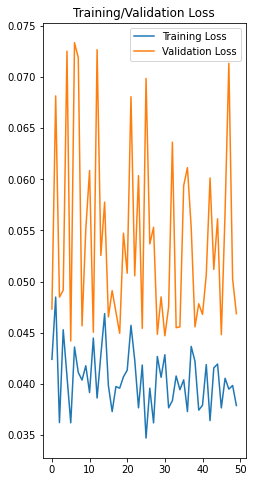

[array([[2509.6042, 2509.5166]], dtype=float32)]
[array([[2509.6042, 2509.5166]], dtype=float32)]
[2509.6042]


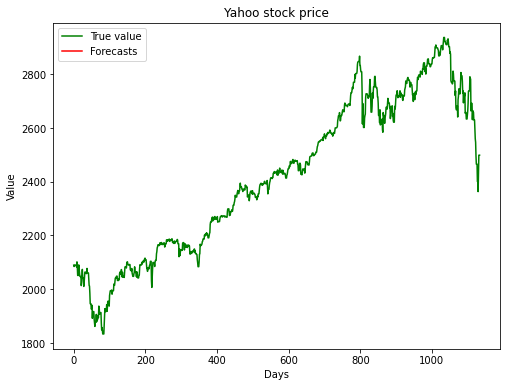

Epoch 1/100
51/51 [==============================] - 5s 25ms/step - loss: 0.3431 - mae: 0.3327 - rmse: 0.3431 - val_loss: 0.0516 - val_mae: 0.0398 - val_rmse: 0.0521
Epoch 2/100
51/51 [==============================] - 0s 9ms/step - loss: 0.1400 - mae: 0.1253 - rmse: 0.1400 - val_loss: 0.0392 - val_mae: 0.0361 - val_rmse: 0.0397
Epoch 3/100
51/51 [==============================] - 0s 9ms/step - loss: 0.1608 - mae: 0.1473 - rmse: 0.1608 - val_loss: 0.0815 - val_mae: 0.0800 - val_rmse: 0.0821
Epoch 4/100
51/51 [==============================] - 0s 9ms/step - loss: 0.1315 - mae: 0.1182 - rmse: 0.1315 - val_loss: 0.0874 - val_mae: 0.0870 - val_rmse: 0.0880
Epoch 5/100
51/51 [==============================] - 0s 9ms/step - loss: 0.1366 - mae: 0.1255 - rmse: 0.1366 - val_loss: 0.0658 - val_mae: 0.0648 - val_rmse: 0.0664

Epoch 00005: val_loss improved from inf to 0.06582, saving model to my_model_5_0.066.h5
Epoch 6/100
51/51 [==============================] - 1s 10ms/step - loss: 0.1520 - ma

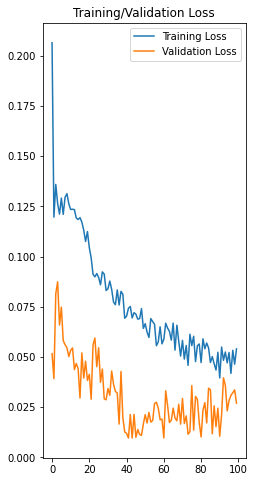

Epoch 1/100
102/102 [==============================] - 1s 10ms/step - loss: 0.0382 - mae: 0.0330 - rmse: 0.0381 - val_loss: 0.0761 - val_mae: 0.0740 - val_rmse: 0.0801
Epoch 2/100
102/102 [==============================] - 1s 9ms/step - loss: 0.0440 - mae: 0.0389 - rmse: 0.0437 - val_loss: 0.0328 - val_mae: 0.0298 - val_rmse: 0.0347
Epoch 3/100
102/102 [==============================] - 1s 9ms/step - loss: 0.0466 - mae: 0.0413 - rmse: 0.0466 - val_loss: 0.0401 - val_mae: 0.0367 - val_rmse: 0.0424
Epoch 4/100
102/102 [==============================] - 1s 9ms/step - loss: 0.0394 - mae: 0.0335 - rmse: 0.0393 - val_loss: 0.0381 - val_mae: 0.0348 - val_rmse: 0.0404
Epoch 5/100
102/102 [==============================] - 1s 9ms/step - loss: 0.0408 - mae: 0.0348 - rmse: 0.0406 - val_loss: 0.0385 - val_mae: 0.0357 - val_rmse: 0.0408

Epoch 00005: val_loss did not improve from 0.01257
Epoch 6/100
102/102 [==============================] - 1s 9ms/step - loss: 0.0385 - mae: 0.0333 - rmse: 0.0386 -

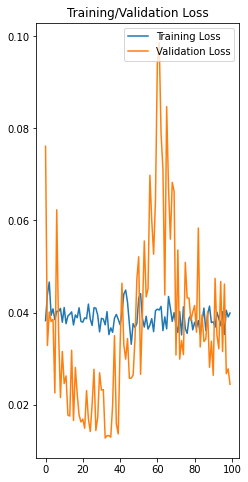

Epoch 1/100
152/152 [==============================] - 3s 7ms/step - loss: 0.0428 - mae: 0.0364 - rmse: 0.0428 - val_loss: 0.0976 - val_mae: 0.0850 - val_rmse: 0.0981
Epoch 2/100
152/152 [==============================] - 1s 7ms/step - loss: 0.0406 - mae: 0.0343 - rmse: 0.0406 - val_loss: 0.0453 - val_mae: 0.0354 - val_rmse: 0.0458
Epoch 3/100
152/152 [==============================] - 1s 7ms/step - loss: 0.0418 - mae: 0.0352 - rmse: 0.0418 - val_loss: 0.0744 - val_mae: 0.0678 - val_rmse: 0.0743
Epoch 4/100
152/152 [==============================] - 1s 7ms/step - loss: 0.0406 - mae: 0.0346 - rmse: 0.0406 - val_loss: 0.0470 - val_mae: 0.0375 - val_rmse: 0.0475
Epoch 5/100
152/152 [==============================] - 1s 7ms/step - loss: 0.0430 - mae: 0.0363 - rmse: 0.0430 - val_loss: 0.0721 - val_mae: 0.0605 - val_rmse: 0.0729

Epoch 00005: val_loss did not improve from 0.01257
Epoch 6/100
152/152 [==============================] - 1s 7ms/step - loss: 0.0383 - mae: 0.0325 - rmse: 0.0383 - 

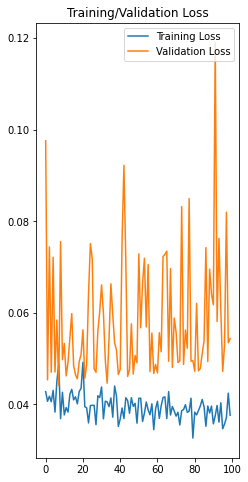

[array([[2501.9514, 2502.013 ]], dtype=float32)]
[array([[2501.9514, 2502.013 ]], dtype=float32)]
[2501.9514]


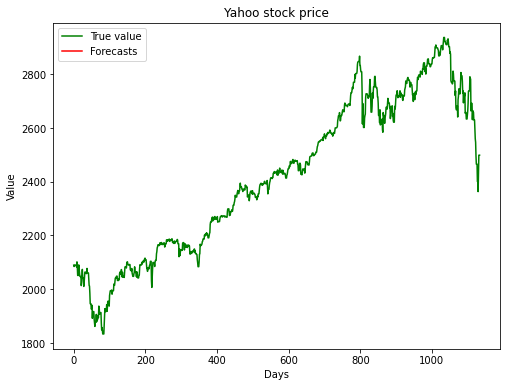

Epoch 1/60
51/51 [==============================] - 5s 25ms/step - loss: 0.2988 - mae: 0.2868 - rmse: 0.2988 - val_loss: 0.0374 - val_mae: 0.0364 - val_rmse: 0.0367
Epoch 2/60
51/51 [==============================] - 1s 10ms/step - loss: 0.1723 - mae: 0.1592 - rmse: 0.1723 - val_loss: 0.0354 - val_mae: 0.0284 - val_rmse: 0.0357
Epoch 3/60
51/51 [==============================] - 1s 11ms/step - loss: 0.1803 - mae: 0.1650 - rmse: 0.1802 - val_loss: 0.0715 - val_mae: 0.0709 - val_rmse: 0.0722
Epoch 4/60
51/51 [==============================] - 1s 10ms/step - loss: 0.1369 - mae: 0.1234 - rmse: 0.1369 - val_loss: 0.0876 - val_mae: 0.0872 - val_rmse: 0.0882
Epoch 5/60
51/51 [==============================] - 1s 10ms/step - loss: 0.1458 - mae: 0.1326 - rmse: 0.1458 - val_loss: 0.0789 - val_mae: 0.0785 - val_rmse: 0.0795

Epoch 00005: val_loss improved from inf to 0.07887, saving model to my_model_5_0.079.h5
Epoch 6/60
51/51 [==============================] - 1s 10ms/step - loss: 0.1448 - mae:

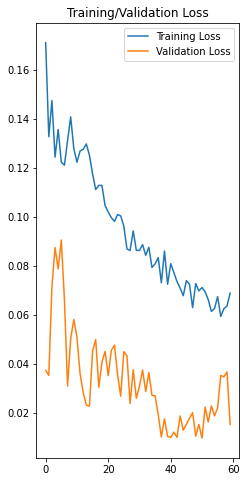

Epoch 1/60
102/102 [==============================] - 1s 10ms/step - loss: 0.0470 - mae: 0.0412 - rmse: 0.0468 - val_loss: 0.0248 - val_mae: 0.0217 - val_rmse: 0.0247
Epoch 2/60
102/102 [==============================] - 1s 9ms/step - loss: 0.0532 - mae: 0.0478 - rmse: 0.0532 - val_loss: 0.0200 - val_mae: 0.0162 - val_rmse: 0.0202
Epoch 3/60
102/102 [==============================] - 1s 10ms/step - loss: 0.0575 - mae: 0.0521 - rmse: 0.0572 - val_loss: 0.0181 - val_mae: 0.0156 - val_rmse: 0.0186
Epoch 4/60
102/102 [==============================] - 1s 10ms/step - loss: 0.0501 - mae: 0.0440 - rmse: 0.0498 - val_loss: 0.0181 - val_mae: 0.0157 - val_rmse: 0.0186
Epoch 5/60
102/102 [==============================] - 1s 10ms/step - loss: 0.0500 - mae: 0.0451 - rmse: 0.0497 - val_loss: 0.0176 - val_mae: 0.0150 - val_rmse: 0.0181

Epoch 00005: val_loss did not improve from 0.01043
Epoch 6/60
102/102 [==============================] - 1s 10ms/step - loss: 0.0461 - mae: 0.0405 - rmse: 0.0458 - v

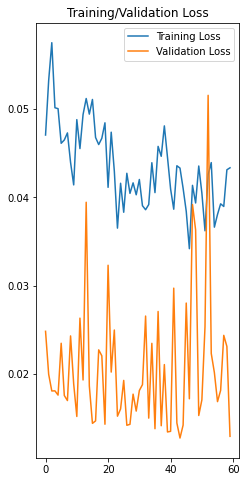

Epoch 1/60
152/152 [==============================] - 2s 10ms/step - loss: 0.0412 - mae: 0.0353 - rmse: 0.0413 - val_loss: 0.1005 - val_mae: 0.0966 - val_rmse: 0.1001
Epoch 2/60
152/152 [==============================] - 1s 10ms/step - loss: 0.0437 - mae: 0.0376 - rmse: 0.0437 - val_loss: 0.0455 - val_mae: 0.0344 - val_rmse: 0.0462
Epoch 3/60
152/152 [==============================] - 1s 9ms/step - loss: 0.0388 - mae: 0.0329 - rmse: 0.0388 - val_loss: 0.0530 - val_mae: 0.0428 - val_rmse: 0.0539
Epoch 4/60
152/152 [==============================] - 1s 10ms/step - loss: 0.0401 - mae: 0.0341 - rmse: 0.0401 - val_loss: 0.0490 - val_mae: 0.0383 - val_rmse: 0.0498
Epoch 5/60
152/152 [==============================] - 1s 10ms/step - loss: 0.0386 - mae: 0.0327 - rmse: 0.0386 - val_loss: 0.0778 - val_mae: 0.0720 - val_rmse: 0.0777

Epoch 00005: val_loss did not improve from 0.01043
Epoch 6/60
152/152 [==============================] - 2s 10ms/step - loss: 0.0439 - mae: 0.0377 - rmse: 0.0439 - v

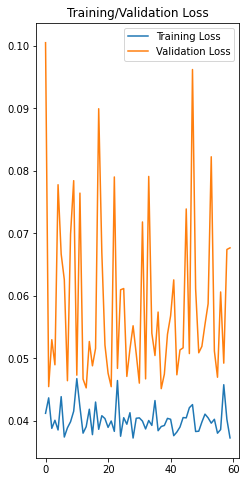

[array([[2495.9316, 2496.0674]], dtype=float32)]
[array([[2495.9316, 2496.0674]], dtype=float32)]
[2495.9316]


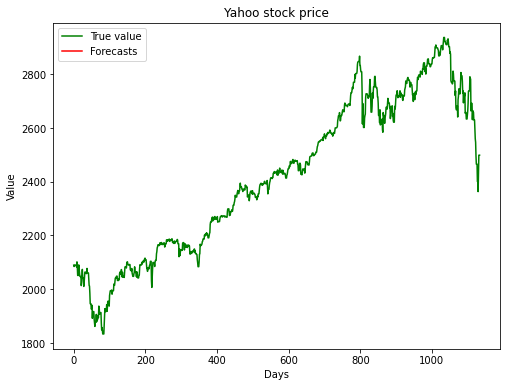

Epoch 1/90
51/51 [==============================] - 4s 26ms/step - loss: 0.2970 - mae: 0.2852 - rmse: 0.2969 - val_loss: 0.0232 - val_mae: 0.0215 - val_rmse: 0.0225
Epoch 2/90
51/51 [==============================] - 1s 11ms/step - loss: 0.1615 - mae: 0.1460 - rmse: 0.1615 - val_loss: 0.0298 - val_mae: 0.0280 - val_rmse: 0.0304
Epoch 3/90
51/51 [==============================] - 1s 11ms/step - loss: 0.1669 - mae: 0.1530 - rmse: 0.1668 - val_loss: 0.0757 - val_mae: 0.0743 - val_rmse: 0.0763
Epoch 4/90
51/51 [==============================] - 1s 10ms/step - loss: 0.1401 - mae: 0.1278 - rmse: 0.1401 - val_loss: 0.0682 - val_mae: 0.0677 - val_rmse: 0.0688
Epoch 5/90
51/51 [==============================] - 1s 10ms/step - loss: 0.1489 - mae: 0.1360 - rmse: 0.1489 - val_loss: 0.0788 - val_mae: 0.0783 - val_rmse: 0.0794

Epoch 00005: val_loss improved from inf to 0.07881, saving model to my_model_5_0.079.h5
Epoch 6/90
51/51 [==============================] - 1s 11ms/step - loss: 0.1430 - mae:

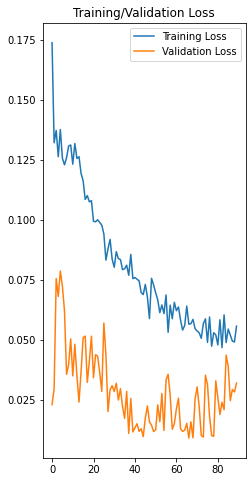

Epoch 1/90
102/102 [==============================] - 1s 11ms/step - loss: 0.0369 - mae: 0.0317 - rmse: 0.0367 - val_loss: 0.0685 - val_mae: 0.0661 - val_rmse: 0.0726
Epoch 2/90
102/102 [==============================] - 1s 10ms/step - loss: 0.0433 - mae: 0.0381 - rmse: 0.0432 - val_loss: 0.0490 - val_mae: 0.0469 - val_rmse: 0.0518
Epoch 3/90
102/102 [==============================] - 1s 10ms/step - loss: 0.0419 - mae: 0.0366 - rmse: 0.0417 - val_loss: 0.0386 - val_mae: 0.0353 - val_rmse: 0.0412
Epoch 4/90
102/102 [==============================] - 1s 10ms/step - loss: 0.0473 - mae: 0.0423 - rmse: 0.0470 - val_loss: 0.0457 - val_mae: 0.0434 - val_rmse: 0.0482
Epoch 5/90
102/102 [==============================] - 1s 10ms/step - loss: 0.0362 - mae: 0.0312 - rmse: 0.0362 - val_loss: 0.0329 - val_mae: 0.0297 - val_rmse: 0.0351

Epoch 00005: val_loss did not improve from 0.00982
Epoch 6/90
102/102 [==============================] - 1s 10ms/step - loss: 0.0410 - mae: 0.0359 - rmse: 0.0411 - 

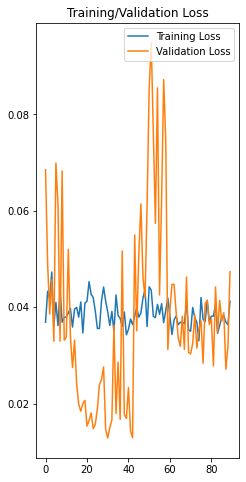

Epoch 1/90
152/152 [==============================] - 2s 10ms/step - loss: 0.0420 - mae: 0.0358 - rmse: 0.0421 - val_loss: 0.0494 - val_mae: 0.0401 - val_rmse: 0.0500
Epoch 2/90
152/152 [==============================] - 2s 10ms/step - loss: 0.0379 - mae: 0.0315 - rmse: 0.0379 - val_loss: 0.0877 - val_mae: 0.0821 - val_rmse: 0.0875
Epoch 3/90
152/152 [==============================] - 2s 10ms/step - loss: 0.0360 - mae: 0.0302 - rmse: 0.0360 - val_loss: 0.0719 - val_mae: 0.0654 - val_rmse: 0.0719
Epoch 4/90
152/152 [==============================] - 2s 10ms/step - loss: 0.0374 - mae: 0.0315 - rmse: 0.0374 - val_loss: 0.1029 - val_mae: 0.0982 - val_rmse: 0.1025
Epoch 5/90
152/152 [==============================] - 2s 10ms/step - loss: 0.0443 - mae: 0.0388 - rmse: 0.0444 - val_loss: 0.0693 - val_mae: 0.0626 - val_rmse: 0.0694

Epoch 00005: val_loss did not improve from 0.00982
Epoch 6/90
152/152 [==============================] - 2s 10ms/step - loss: 0.0417 - mae: 0.0357 - rmse: 0.0417 - 

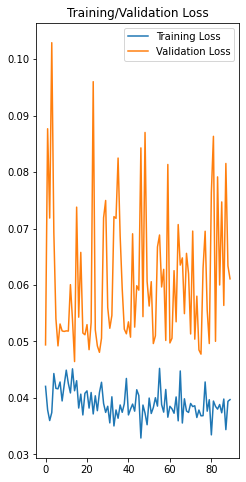

[array([[2509.9165, 2509.9236]], dtype=float32)]
[array([[2509.9165, 2509.9236]], dtype=float32)]
[2509.9165]


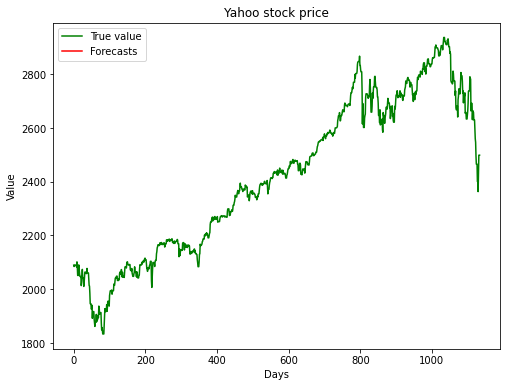

Epoch 1/120
51/51 [==============================] - 4s 27ms/step - loss: 0.2564 - mae: 0.2438 - rmse: 0.2564 - val_loss: 0.0223 - val_mae: 0.0190 - val_rmse: 0.0217
Epoch 2/120
51/51 [==============================] - 1s 11ms/step - loss: 0.1311 - mae: 0.1162 - rmse: 0.1310 - val_loss: 0.0237 - val_mae: 0.0225 - val_rmse: 0.0231
Epoch 3/120
51/51 [==============================] - 1s 11ms/step - loss: 0.1924 - mae: 0.1807 - rmse: 0.1924 - val_loss: 0.0533 - val_mae: 0.0459 - val_rmse: 0.0539
Epoch 4/120
51/51 [==============================] - 1s 12ms/step - loss: 0.1548 - mae: 0.1416 - rmse: 0.1548 - val_loss: 0.0721 - val_mae: 0.0715 - val_rmse: 0.0727
Epoch 5/120
51/51 [==============================] - 1s 10ms/step - loss: 0.1472 - mae: 0.1353 - rmse: 0.1471 - val_loss: 0.0799 - val_mae: 0.0794 - val_rmse: 0.0805

Epoch 00005: val_loss improved from inf to 0.07991, saving model to my_model_5_0.080.h5
Epoch 6/120
51/51 [==============================] - 1s 11ms/step - loss: 0.1340 

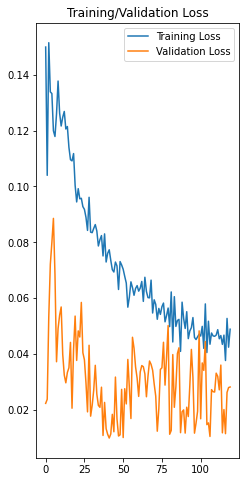

Epoch 1/120
102/102 [==============================] - 1s 11ms/step - loss: 0.0365 - mae: 0.0319 - rmse: 0.0367 - val_loss: 0.0246 - val_mae: 0.0205 - val_rmse: 0.0255
Epoch 2/120
102/102 [==============================] - 1s 10ms/step - loss: 0.0429 - mae: 0.0377 - rmse: 0.0428 - val_loss: 0.0381 - val_mae: 0.0359 - val_rmse: 0.0396
Epoch 3/120
102/102 [==============================] - 1s 10ms/step - loss: 0.0453 - mae: 0.0400 - rmse: 0.0452 - val_loss: 0.0445 - val_mae: 0.0426 - val_rmse: 0.0461
Epoch 4/120
102/102 [==============================] - 1s 10ms/step - loss: 0.0389 - mae: 0.0343 - rmse: 0.0390 - val_loss: 0.0184 - val_mae: 0.0154 - val_rmse: 0.0192
Epoch 5/120
102/102 [==============================] - 1s 10ms/step - loss: 0.0440 - mae: 0.0388 - rmse: 0.0438 - val_loss: 0.0502 - val_mae: 0.0493 - val_rmse: 0.0492

Epoch 00005: val_loss did not improve from 0.01171
Epoch 6/120
102/102 [==============================] - 1s 11ms/step - loss: 0.0407 - mae: 0.0356 - rmse: 0.0

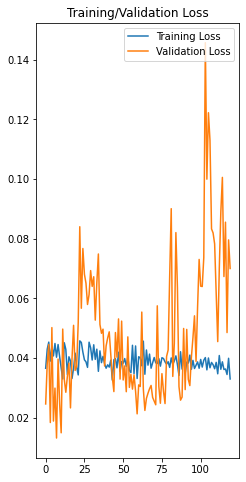

Epoch 1/120
152/152 [==============================] - 2s 11ms/step - loss: 0.0462 - mae: 0.0392 - rmse: 0.0463 - val_loss: 0.0826 - val_mae: 0.0717 - val_rmse: 0.0832
Epoch 2/120
152/152 [==============================] - 2s 10ms/step - loss: 0.0396 - mae: 0.0334 - rmse: 0.0397 - val_loss: 0.0981 - val_mae: 0.0920 - val_rmse: 0.0979
Epoch 3/120
152/152 [==============================] - 2s 10ms/step - loss: 0.0420 - mae: 0.0359 - rmse: 0.0420 - val_loss: 0.0696 - val_mae: 0.0618 - val_rmse: 0.0696
Epoch 4/120
152/152 [==============================] - 2s 10ms/step - loss: 0.0406 - mae: 0.0346 - rmse: 0.0407 - val_loss: 0.1107 - val_mae: 0.1053 - val_rmse: 0.1103
Epoch 5/120
152/152 [==============================] - 2s 10ms/step - loss: 0.0384 - mae: 0.0320 - rmse: 0.0384 - val_loss: 0.0960 - val_mae: 0.0906 - val_rmse: 0.0957

Epoch 00005: val_loss did not improve from 0.01171
Epoch 6/120
152/152 [==============================] - 2s 10ms/step - loss: 0.0405 - mae: 0.0345 - rmse: 0.0

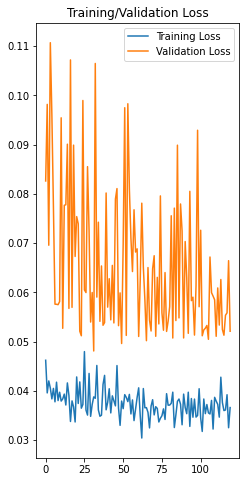

[array([[2503.4019, 2503.4153]], dtype=float32)]
[array([[2503.4019, 2503.4153]], dtype=float32)]
[2503.4019]


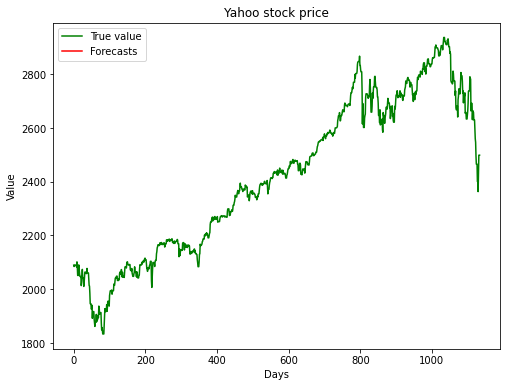

Epoch 1/50
32/32 [==============================] - 4s 40ms/step - loss: 0.4096 - mae: 0.3969 - rmse: 0.4095 - val_loss: 0.0264 - val_mae: 0.0231 - val_rmse: 0.0303
Epoch 2/50
32/32 [==============================] - 0s 14ms/step - loss: 0.1447 - mae: 0.1247 - rmse: 0.1446 - val_loss: 0.0315 - val_mae: 0.0284 - val_rmse: 0.0344
Epoch 3/50
32/32 [==============================] - 0s 14ms/step - loss: 0.1531 - mae: 0.1382 - rmse: 0.1531 - val_loss: 0.0276 - val_mae: 0.0245 - val_rmse: 0.0312
Epoch 4/50
32/32 [==============================] - 0s 13ms/step - loss: 0.1525 - mae: 0.1382 - rmse: 0.1524 - val_loss: 0.0208 - val_mae: 0.0179 - val_rmse: 0.0258
Epoch 5/50
32/32 [==============================] - 0s 14ms/step - loss: 0.1642 - mae: 0.1485 - rmse: 0.1642 - val_loss: 0.0234 - val_mae: 0.0183 - val_rmse: 0.0296

Epoch 00005: val_loss improved from inf to 0.02336, saving model to my_model_5_0.023.h5
Epoch 6/50
32/32 [==============================] - 0s 14ms/step - loss: 0.1855 - mae:

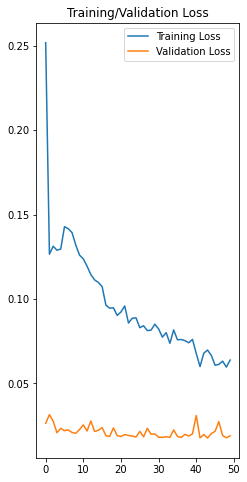

Epoch 1/50
64/64 [==============================] - 2s 33ms/step - loss: 0.0459 - mae: 0.0384 - rmse: 0.0459 - val_loss: 0.0180 - val_mae: 0.0148 - val_rmse: 0.0180
Epoch 2/50
64/64 [==============================] - 1s 13ms/step - loss: 0.0467 - mae: 0.0395 - rmse: 0.0467 - val_loss: 0.0202 - val_mae: 0.0160 - val_rmse: 0.0202
Epoch 3/50
64/64 [==============================] - 1s 13ms/step - loss: 0.0444 - mae: 0.0372 - rmse: 0.0441 - val_loss: 0.0214 - val_mae: 0.0167 - val_rmse: 0.0214
Epoch 4/50
64/64 [==============================] - 1s 13ms/step - loss: 0.0423 - mae: 0.0356 - rmse: 0.0420 - val_loss: 0.0181 - val_mae: 0.0147 - val_rmse: 0.0181
Epoch 5/50
64/64 [==============================] - 1s 12ms/step - loss: 0.0465 - mae: 0.0392 - rmse: 0.0462 - val_loss: 0.0225 - val_mae: 0.0181 - val_rmse: 0.0225

Epoch 00005: val_loss did not improve from 0.01825
Epoch 6/50
64/64 [==============================] - 1s 13ms/step - loss: 0.0440 - mae: 0.0372 - rmse: 0.0439 - val_loss: 0.

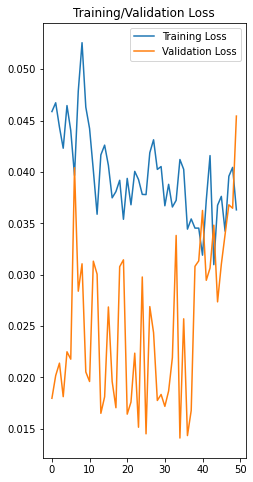

Epoch 1/50
95/95 [==============================] - 1s 13ms/step - loss: 0.0389 - mae: 0.0330 - rmse: 0.0389 - val_loss: 0.0525 - val_mae: 0.0430 - val_rmse: 0.0546
Epoch 2/50
95/95 [==============================] - 1s 12ms/step - loss: 0.0421 - mae: 0.0357 - rmse: 0.0422 - val_loss: 0.0493 - val_mae: 0.0397 - val_rmse: 0.0522
Epoch 3/50
95/95 [==============================] - 1s 13ms/step - loss: 0.0331 - mae: 0.0271 - rmse: 0.0332 - val_loss: 0.0519 - val_mae: 0.0429 - val_rmse: 0.0542
Epoch 4/50
95/95 [==============================] - 1s 13ms/step - loss: 0.0341 - mae: 0.0276 - rmse: 0.0341 - val_loss: 0.0480 - val_mae: 0.0394 - val_rmse: 0.0518
Epoch 5/50
95/95 [==============================] - 1s 13ms/step - loss: 0.0374 - mae: 0.0309 - rmse: 0.0374 - val_loss: 0.0672 - val_mae: 0.0604 - val_rmse: 0.0674

Epoch 00005: val_loss did not improve from 0.01410
Epoch 6/50
95/95 [==============================] - 1s 13ms/step - loss: 0.0356 - mae: 0.0295 - rmse: 0.0357 - val_loss: 0.

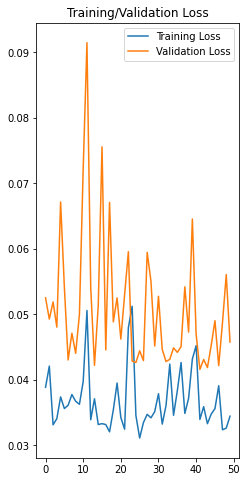

[array([[2472.2092, 2472.464 ]], dtype=float32)]
[array([[2472.2092, 2472.464 ]], dtype=float32)]
[2472.2092]


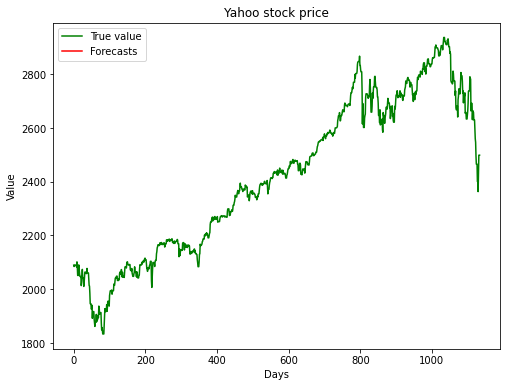

Epoch 1/90
32/32 [==============================] - 4s 39ms/step - loss: 0.3825 - mae: 0.3680 - rmse: 0.3824 - val_loss: 0.0486 - val_mae: 0.0395 - val_rmse: 0.0500
Epoch 2/90
32/32 [==============================] - 0s 13ms/step - loss: 0.1395 - mae: 0.1205 - rmse: 0.1394 - val_loss: 0.0304 - val_mae: 0.0283 - val_rmse: 0.0333
Epoch 3/90
32/32 [==============================] - 0s 14ms/step - loss: 0.1458 - mae: 0.1288 - rmse: 0.1457 - val_loss: 0.0230 - val_mae: 0.0195 - val_rmse: 0.0276
Epoch 4/90
32/32 [==============================] - 0s 14ms/step - loss: 0.1556 - mae: 0.1420 - rmse: 0.1556 - val_loss: 0.0213 - val_mae: 0.0169 - val_rmse: 0.0267
Epoch 5/90
32/32 [==============================] - 0s 13ms/step - loss: 0.1605 - mae: 0.1462 - rmse: 0.1604 - val_loss: 0.0233 - val_mae: 0.0191 - val_rmse: 0.0288

Epoch 00005: val_loss improved from inf to 0.02331, saving model to my_model_5_0.023.h5
Epoch 6/90
32/32 [==============================] - 0s 14ms/step - loss: 0.1764 - mae:

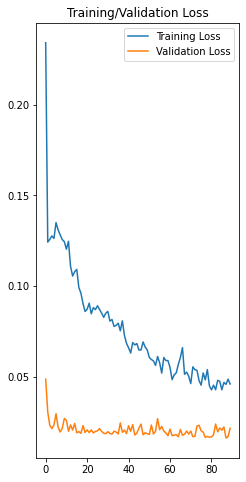

Epoch 1/90
64/64 [==============================] - 2s 26ms/step - loss: 0.0384 - mae: 0.0322 - rmse: 0.0390 - val_loss: 0.0618 - val_mae: 0.0602 - val_rmse: 0.0618
Epoch 2/90
64/64 [==============================] - 1s 13ms/step - loss: 0.0380 - mae: 0.0316 - rmse: 0.0381 - val_loss: 0.0295 - val_mae: 0.0268 - val_rmse: 0.0295
Epoch 3/90
64/64 [==============================] - 1s 13ms/step - loss: 0.0415 - mae: 0.0350 - rmse: 0.0414 - val_loss: 0.0166 - val_mae: 0.0128 - val_rmse: 0.0166
Epoch 4/90
64/64 [==============================] - 1s 13ms/step - loss: 0.0361 - mae: 0.0305 - rmse: 0.0362 - val_loss: 0.0178 - val_mae: 0.0143 - val_rmse: 0.0178
Epoch 5/90
64/64 [==============================] - 1s 13ms/step - loss: 0.0374 - mae: 0.0316 - rmse: 0.0375 - val_loss: 0.0276 - val_mae: 0.0244 - val_rmse: 0.0276

Epoch 00005: val_loss did not improve from 0.01653
Epoch 6/90
64/64 [==============================] - 1s 13ms/step - loss: 0.0339 - mae: 0.0280 - rmse: 0.0339 - val_loss: 0.

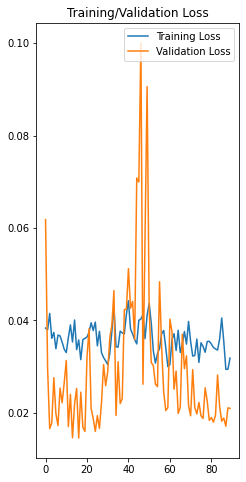

Epoch 1/90
95/95 [==============================] - 1s 14ms/step - loss: 0.0429 - mae: 0.0362 - rmse: 0.0431 - val_loss: 0.0934 - val_mae: 0.0883 - val_rmse: 0.0918
Epoch 2/90
95/95 [==============================] - 1s 13ms/step - loss: 0.0383 - mae: 0.0313 - rmse: 0.0383 - val_loss: 0.0768 - val_mae: 0.0706 - val_rmse: 0.0759
Epoch 3/90
95/95 [==============================] - 1s 13ms/step - loss: 0.0374 - mae: 0.0314 - rmse: 0.0374 - val_loss: 0.0537 - val_mae: 0.0470 - val_rmse: 0.0544
Epoch 4/90
95/95 [==============================] - 1s 13ms/step - loss: 0.0330 - mae: 0.0273 - rmse: 0.0330 - val_loss: 0.0450 - val_mae: 0.0344 - val_rmse: 0.0469
Epoch 5/90
95/95 [==============================] - 1s 13ms/step - loss: 0.0331 - mae: 0.0270 - rmse: 0.0332 - val_loss: 0.0460 - val_mae: 0.0347 - val_rmse: 0.0483

Epoch 00005: val_loss did not improve from 0.01600
Epoch 6/90
95/95 [==============================] - 1s 12ms/step - loss: 0.0359 - mae: 0.0301 - rmse: 0.0359 - val_loss: 0.

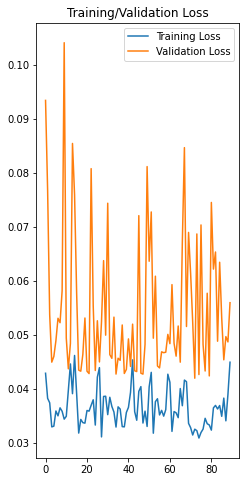

[array([[2488.1545, 2488.141 ]], dtype=float32)]
[array([[2488.1545, 2488.141 ]], dtype=float32)]
[2488.1545]


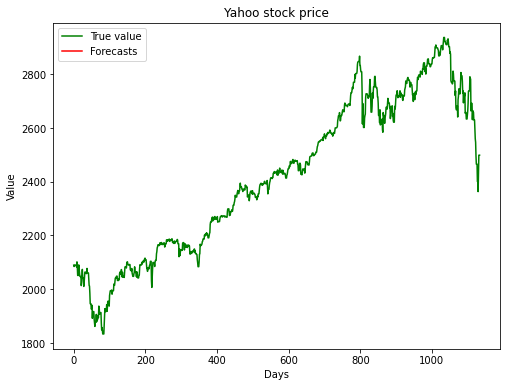

Epoch 1/120
32/32 [==============================] - 4s 40ms/step - loss: 0.3975 - mae: 0.3841 - rmse: 0.3975 - val_loss: 0.0246 - val_mae: 0.0210 - val_rmse: 0.0289
Epoch 2/120
32/32 [==============================] - 0s 14ms/step - loss: 0.1465 - mae: 0.1262 - rmse: 0.1465 - val_loss: 0.0251 - val_mae: 0.0205 - val_rmse: 0.0296
Epoch 3/120
32/32 [==============================] - 0s 15ms/step - loss: 0.1552 - mae: 0.1373 - rmse: 0.1552 - val_loss: 0.0189 - val_mae: 0.0154 - val_rmse: 0.0249
Epoch 4/120
32/32 [==============================] - 0s 15ms/step - loss: 0.1609 - mae: 0.1471 - rmse: 0.1608 - val_loss: 0.0223 - val_mae: 0.0176 - val_rmse: 0.0286
Epoch 5/120
32/32 [==============================] - 0s 15ms/step - loss: 0.1702 - mae: 0.1567 - rmse: 0.1701 - val_loss: 0.0238 - val_mae: 0.0192 - val_rmse: 0.0301

Epoch 00005: val_loss improved from inf to 0.02385, saving model to my_model_5_0.024.h5
Epoch 6/120
32/32 [==============================] - 0s 14ms/step - loss: 0.1942 

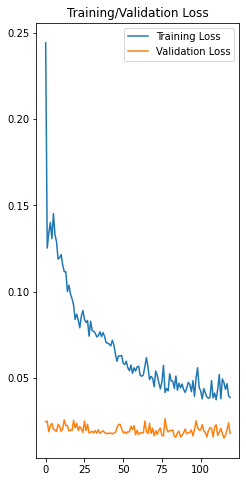

Epoch 1/120
64/64 [==============================] - 2s 35ms/step - loss: 0.0334 - mae: 0.0276 - rmse: 0.0332 - val_loss: 0.0656 - val_mae: 0.0628 - val_rmse: 0.0656
Epoch 2/120
64/64 [==============================] - 1s 14ms/step - loss: 0.0362 - mae: 0.0304 - rmse: 0.0369 - val_loss: 0.0572 - val_mae: 0.0560 - val_rmse: 0.0572
Epoch 3/120
64/64 [==============================] - 1s 14ms/step - loss: 0.0338 - mae: 0.0278 - rmse: 0.0338 - val_loss: 0.0381 - val_mae: 0.0366 - val_rmse: 0.0381
Epoch 4/120
64/64 [==============================] - 1s 14ms/step - loss: 0.0359 - mae: 0.0302 - rmse: 0.0357 - val_loss: 0.0146 - val_mae: 0.0108 - val_rmse: 0.0146
Epoch 5/120
64/64 [==============================] - 1s 14ms/step - loss: 0.0375 - mae: 0.0309 - rmse: 0.0373 - val_loss: 0.0196 - val_mae: 0.0161 - val_rmse: 0.0196

Epoch 00005: val_loss did not improve from 0.01589
Epoch 6/120
64/64 [==============================] - 1s 13ms/step - loss: 0.0375 - mae: 0.0312 - rmse: 0.0376 - val_lo

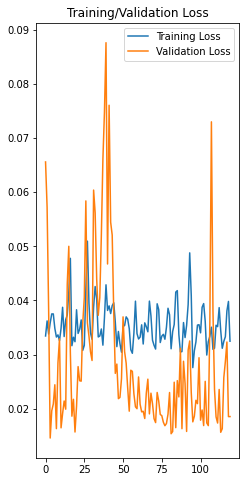

Epoch 1/120
95/95 [==============================] - 1s 14ms/step - loss: 0.0363 - mae: 0.0296 - rmse: 0.0363 - val_loss: 0.0572 - val_mae: 0.0505 - val_rmse: 0.0575
Epoch 2/120
95/95 [==============================] - 1s 13ms/step - loss: 0.0405 - mae: 0.0341 - rmse: 0.0405 - val_loss: 0.0562 - val_mae: 0.0477 - val_rmse: 0.0596
Epoch 3/120
95/95 [==============================] - 1s 13ms/step - loss: 0.0380 - mae: 0.0313 - rmse: 0.0381 - val_loss: 0.0439 - val_mae: 0.0337 - val_rmse: 0.0467
Epoch 4/120
95/95 [==============================] - 1s 14ms/step - loss: 0.0365 - mae: 0.0301 - rmse: 0.0365 - val_loss: 0.0433 - val_mae: 0.0333 - val_rmse: 0.0459
Epoch 5/120
95/95 [==============================] - 1s 13ms/step - loss: 0.0370 - mae: 0.0307 - rmse: 0.0372 - val_loss: 0.0435 - val_mae: 0.0343 - val_rmse: 0.0457

Epoch 00005: val_loss did not improve from 0.01572
Epoch 6/120
95/95 [==============================] - 1s 13ms/step - loss: 0.0365 - mae: 0.0297 - rmse: 0.0366 - val_lo

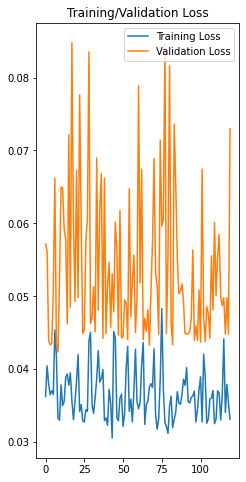

[array([[2483.8694, 2484.0034]], dtype=float32)]
[array([[2483.8694, 2484.0034]], dtype=float32)]
[2483.8694]


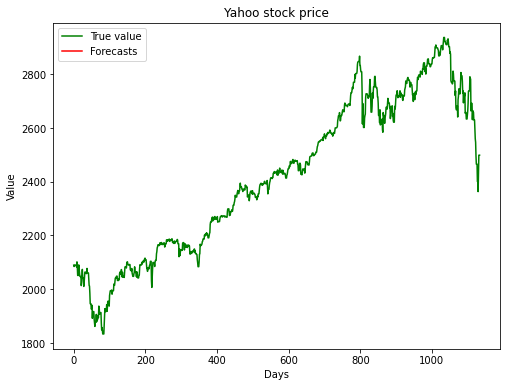

In [17]:
for t in tunning_dict:
  #print(record[r])
  # fitting the model
  timesteps = tunning_dict[t]['timesteps']
  epochs = tunning_dict[t]['epochs']
  batch_size= tunning_dict[t]['batch_size']
  multisteps= tunning_dict[t]['multisteps']
  cv_splits = tunning_dict[t]['cv_splits']
  #print(timesteps,epochs,batch_size,cv_splits)

  X, y = to_supervised(df, timesteps)

  model = build_model(timesteps, n_variate)
  model, history = compile_and_fit(model, epochs, batch_size)
  path_to_save=r'modelo_aux_close_'+str(t)+'.h5'
  model.save(path_to_save)
  #print("df: ",df.shape," timesteps",timesteps," multisteps ",multisteps)
  forecasts = forecast(model, df, timesteps, multisteps, scaler)

  print(forecasts)

  prev = []

  #plot do valor previsto da ação de Open
  for f in forecasts:
    prev.append(f[0][0])

  print(prev)
  plot_forecast(df_raw, prev)

  #Scorer
  

  record[t] = history

In [18]:
id_tunning = 1
id_split =1

final_dict = {}

for r in record:
#print(tunning_dict[1]['epochs'])
  loss = []
  mae =[]
  rmse = []
  val_loss = []
  val_mae = []
  val_rmse = []

  for h in record[r]:
    #print("Tunning ID:  ",id_tunning," Split ID: ",id_split)
    #plot_learning_curves(h, tunning_dict[id_tunning]['epochs'])
    #['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse']
    #print("loss: ",sum(h.history['loss'])/len(h.history['loss'])," MAE: ",sum(h.history['mae'])/len(h.history['mae'])," RMSE: ",sum(h.history['rmse'])/len(h.history['rmse'])," VAL_LOSS: ",sum(h.history['val_loss'])/len(h.history['val_loss'])," VAL_MAE: ",sum(h.history['val_mae'])/len(h.history['val_mae'])," VAL_RMSE: ",sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    loss.append(sum(h.history['loss'])/len(h.history['loss']))
    mae.append(sum(h.history['mae'])/len(h.history['mae']))
    rmse.append(sum(h.history['rmse'])/len(h.history['rmse']))
    val_loss.append(sum(h.history['val_loss'])/len(h.history['val_loss']))
    val_mae.append(sum(h.history['val_mae'])/len(h.history['val_mae']))
    val_rmse.append(sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    id_split+=1
  id_split=1
  
  final_dict[id_tunning]=[sum(loss)/len(loss), sum(mae)/len(mae),sum(rmse)/len(rmse),sum(val_loss)/len(val_loss),sum(val_mae)/len(val_mae), sum(val_rmse)/len(val_rmse)]

  id_tunning=id_tunning+1



In [19]:
for f in final_dict:
  print("Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE")
  print("ID tunning: ",f, " Valores: ",final_dict[f],"\n")

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  1  Valores:  [0.09620328173041344, 0.08761440739035607, 0.09604293542603652, 0.05813289949049553, 0.05385325855265061, 0.05892271058013041] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  2  Valores:  [0.06145602986216545, 0.05458848802993695, 0.06135536015033722, 0.0373413688937823, 0.032707828115671876, 0.037795443050563336] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  3  Valores:  [0.051892846400539074, 0.04536525031551719, 0.05184822522103786, 0.04194292137399316, 0.03780458128390213, 0.042287896359339355] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  4  Valores:  [0.05957307447161939, 0.052982598543167114, 0.05939771936585506, 0.03741748524933226, 0.03311090651485655, 0.037583266327985455] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  5  Valores:  [0.05286500473265295, 0.04647265497457098, 0.05275950307647387, 0.04251681733876467, 0.038364144255

In [20]:
final_df = pd.DataFrame.from_dict(final_dict, orient='index')
final_df.columns = ['Loss','MAE','RMSE','VAL_LOSS','VAL_MAE','VAL_RMSE']
final_df

,Loss,MAE,RMSE,VAL_LOSS,VAL_MAE,VAL_RMSE
1,0.096203,0.087614,0.096043,0.058133,0.053853,0.058923
2,0.061456,0.054588,0.061355,0.037341,0.032708,0.037795
3,0.051893,0.045365,0.051848,0.041943,0.037805,0.042288
4,0.059573,0.052983,0.059398,0.037417,0.033111,0.037583
5,0.052865,0.046473,0.052760,0.042517,0.038364,0.043006
6,0.049534,0.043377,0.049472,0.048218,0.044110,0.049059
7,0.057460,0.049582,0.057278,0.032376,0.027034,0.034893
8,0.049399,0.042101,0.049278,0.034852,0.029662,0.037151
9,0.046388,0.039329,0.046297,0.034195,0.028953,0.036473


In [21]:
final_df.to_csv(r"resultados_close.csv",index=True)